Ordinary Least Squares Regression (OLS)
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: Derivation and examples of [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares). For more information, see [All Models Are Wrong](https://allmodelsarewrong.github.io/ols.html).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/gallery/ols.ipynb)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
if 'google.colab' in str(get_ipython()):
    !wget https://github.com/mahynski/pychemauth/raw/main/docs/jupyter/gallery/utils.py
        
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [3]:
import utils

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from pychemauth.preprocessing.scaling import CorrectedScaler

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

json      : 2.0.9
pychemauth: 0.0.0b3
matplotlib: 3.7.2
numpy     : 1.24.3
watermark : 2.4.3



<h3>Create some Data</h3>

For this notebook we will generate some synthetic data.  Here, we have a dataset with 2 features and a certain multivariate normal distribution.

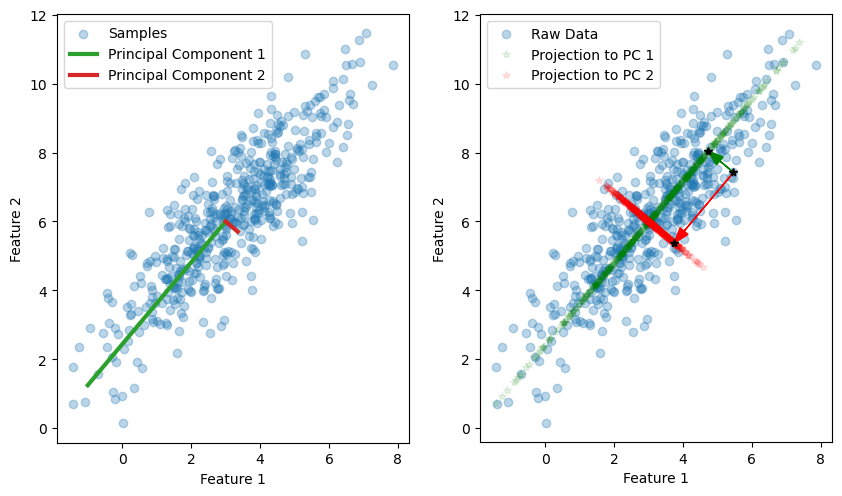

In [5]:
X = utils.generate_data(mean=[3,6], cov=[[3, 3], [3, 4]], n_samples=500)

# For this example, we will generate a response correlated with the first eigenvector (Com0)
y, pca_gen = utils.generate_response(X, 0, mean=[3,6], seed=1, y_center=10, display=False) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

utils.visualize_data(X, mean=[3,6])

OLS
---

OLS stands for [ordinary least squares regression](https://en.wikipedia.org/wiki/Ordinary_least_squares). This is generally considered to be the simplest of all regression methods.

We want to develop a model for some scalar response variable, $\vec{y}$, in terms of $p$ explanatory variables, or features stored in a matrix $X$.  The dimensions of $X$ are $n \times p$; assume $\vec{y}$ is a column vector ($n \times 1$) with a single scalar value for each row in $X$.

$$y_0 = b_0 +b_1x_{0,1}+\dots b_px_{0,p}$$

$$y_1 = b_0 +b_1x_{1,1}+\dots b_px_{1,p}$$

$$\dots$$

In matrix form we can write $\vec{y} = X\vec{b} + \vec{e}$, where $\vec{e}$ is some error and $\vec{b}$ is a vector of coefficients of the size ($p \times 1$). $\vec{b}$ needs to be solved for.  This is done by minimizing the square error, $err = \sum (\vec{y} - X\vec{b})^2$, hence the name "least squares regression".  To solve this we can take the derivative and set it equal to zero.  Thus, we arrive at:

$$-2X^T(\vec{y} - X\vec{b}) = 0,$$

$$X^T\vec{y} = X^TX\vec{b},$$

$$\vec{b} = (X^TX)^{-1}X^T\vec{y}.$$

The canonical problem is evaluating $(X^TX)^{-1}$.  Often times either

1. $X$ is very large and this hard to do, or 
2. $X$ is not invertible.

Note that in the above equations we have a constant $b_0$; implicitly, $x_{i,0} = 1$ for all $i < n$.  We could add another dimension to $X$ so its first column is a constant value of 1, then fit (use `fit_intercept=True` option below). However, this  adds another essentially meaningless column since it is just a shift.  A better approach is to mean-center $\vec{y}$ so instead we have

$$y_0-b_0 = b_1x_{0,1}+\dots b_px_{0,p}$$

$$y_1-b_0 = b_1x_{1,1}+\dots b_px_{1,p}$$

$$\dots$$

where now the shift is incorporated implicitly on the left hand side.  

In [6]:
ss = CorrectedScaler(with_std=False, with_mean=True) # Mean center, but don't scale for this example

B = np.matmul(
    np.matmul(
        np.linalg.inv(
            np.matmul(X_train.T, X_train)
        ), 
        X_train.T),
    ss.fit_transform(y_train.reshape(-1,1))
)

In [7]:
B

array([[-1.61800293],
       [ 0.73825064]])

In [8]:
# sklearn has a simple tool for doing this easily
regr = LinearRegression(
    fit_intercept=False, 
)
_ = regr.fit(
    X_train, 
    ss.transform(y_train.reshape(-1,1))
)

In [9]:
regr.coef_

array([[-1.61800293,  0.73825064]])

The `score` function returns the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), or $R^2$.

In [10]:
regr.score(X_train , ss.transform(y_train.reshape(-1,1)))

0.47495352612934205

In [11]:
regr.intercept_ # Since we set fit_intercept=False this is kept to 0.0

0.0

In [12]:
# We need to de-center to compare to our original y values
y_pred_sklearn = ss.inverse_transform(regr.predict(X_test))
y_pred_manual = ss.inverse_transform(np.matmul(X_test, B))

In [13]:
np.allclose(y_pred_manual, y_pred_sklearn)

True

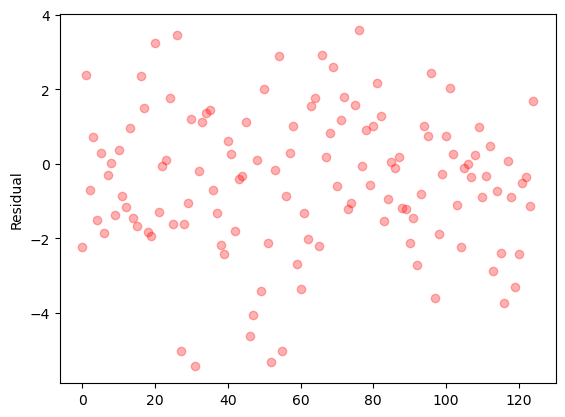

In [14]:
# We can plot the error
plt.plot(y_pred_sklearn-y_test.reshape(-1,1), 'ro', alpha=0.3)
_ = plt.ylabel('Residual')

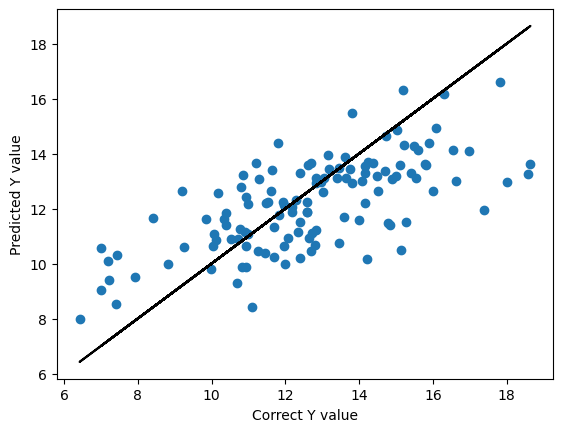

In [15]:
plt.plot(y_test, y_pred_sklearn, 'o')
plt.plot(y_test, y_test, 'k-')
plt.xlabel('Correct Y value')
_ = plt.ylabel('Predicted Y value')

Ridge Regression (L2 regularization)
---

However, when we have many terms (e.g., $p > n$) we can start to overfit to our model.  Overfitting is often characterized by coefficients with large values, for example, consider polynomials functions with large coefficients of alternating sign. 

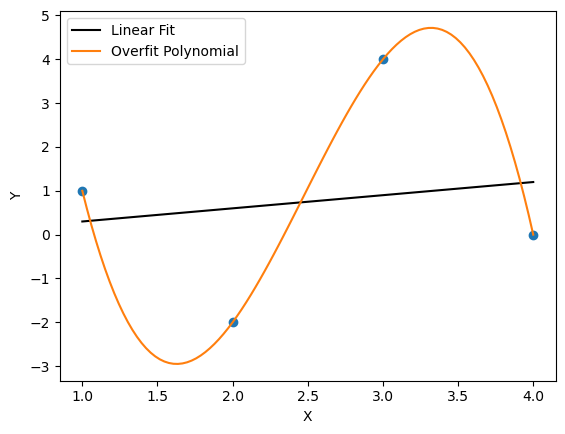

In [16]:
# Some example data
X_ = np.array([1, 2, 3, 4]).reshape(-1,1)
y_ = [1, -2, 4, 0]

# Fit a simple line
regr = LinearRegression(
    fit_intercept=True, 
)
_ = regr.fit(
    X_, 
    y_
)

# Fit a 3rd degree polynomial
coef = np.polyfit(X_.ravel(), y_, deg=3)
p = np.poly1d(coef)
xt_ = np.linspace(1, 4, 100)

# Plot a comparison
plt.plot(X_, y_, 'o')
plt.plot(X_, regr.predict(X_), 'k-', label='Linear Fit')
_ = plt.plot(xt_, [p(x) for x in xt_], label='Overfit Polynomial')
_ = plt.legend(loc='best')
_ = plt.xlabel('X')
_ = plt.ylabel('Y')

In [17]:
# The linear coeficient is order unity
regr.coef_

array([0.3])

In [18]:
# While the higher order polynomial coefficients are 2 orders of magnitude larger
coef

array([ -3.16666667,  23.5       , -51.33333333,  32.        ])

[Ridge regression](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) is simple OLS with a regularization penalty applied (L2 norm) which penalizes the coefficients for becoming large. The ridge coefficients minimize a penalized residual sum of squares:

${\rm min} ||X\vec{b} -\vec{y} ||_2^2  + \alpha || \vec{b} ||_2^2$

Thus, when $\alpha = 0$ we recover conventional OLS since the residual sum of squares dominates, but as $\alpha$ gets larger the size of the coefficients dominates instead.  The ideal value of $\alpha$ is a hyperparameter that should be optimized.

It has been suggested that ridge would be prefereable to [PLS](pls.ipynb) since it also reduces covariant features
but it tends to be simpler to interpret and implement.  It is also more specific about which features are
eliminated rather than removing entire PCs which are composed of all of them.  
 - Hastie et al. "The Elements of Statistical Learning"

See sklearn's [user guide](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) for more details.

In [19]:
coef = []
for alpha in np.logspace(-3, 4, 100):
    regr = Ridge(
        fit_intercept=False, 
        alpha=alpha
    )
    _ = regr.fit(
        X_train, 
        ss.transform(y_train.reshape(-1,1))
    )
    coef.append(regr.coef_[0])
coef = np.array(coef)

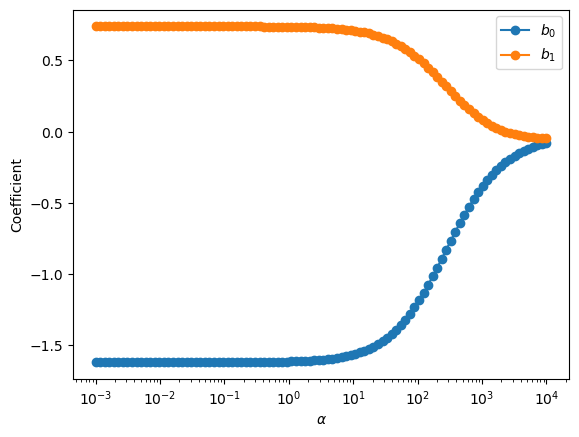

In [20]:
plt.plot(np.logspace(-3, 4, 100), coef[:,0], 'o-', label=r'$b_0$')
plt.plot(np.logspace(-3, 4, 100), coef[:,1], 'o-', label=r'$b_1$')
_ = plt.xlabel(r'$\alpha$')
_ = plt.ylabel('Coefficient')
_ = plt.legend(loc='best')
_ = plt.xscale('log')

As $\alpha$ increases is seems that $b_1$ goes to zero faster and is generally smaller in magnitude, meaning $b_0$ (the first feature) is more important than $b_1$ (the second feature).

LASSO (L1 regularization)
---

[Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso) applies an L1 penalty to OLS.  This results in sparse solutions, that is, certain coefficients are driven identically to zero rather than just very close to zero, as in Ridge.  Here, the objective function is the residual sum of squares with an L1-norm of the coefficients instead of L2.

${\rm min} \frac{1}{2 N_{\rm samples}} ||X\vec{b} -\vec{y} ||_2^2  + \alpha || \vec{b} ||_1$

This is helpful when you have many features and want to build a linear model with only a subset of the most important ones.

In [21]:
coef = []
for alpha in np.logspace(-3, 1, 50):
    regr = Lasso(
        fit_intercept=False, 
        alpha=alpha
    )
    _ = regr.fit(
        X_train, 
        ss.transform(y_train.reshape(-1,1))
    )
    coef.append(regr.coef_)
coef = np.array(coef)

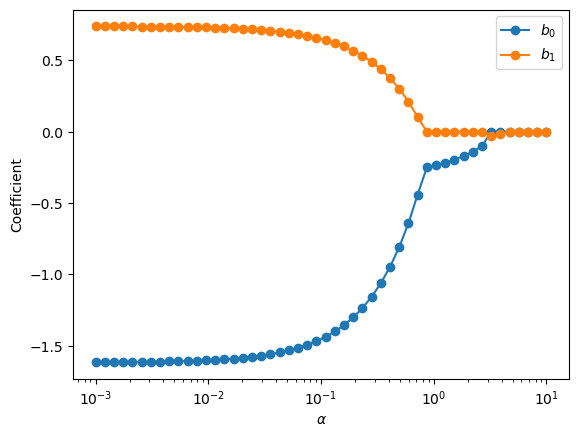

In [22]:
plt.plot(np.logspace(-3, 1, 50), coef[:,0], 'o-', label=r'$b_0$')
plt.plot(np.logspace(-3, 1, 50), coef[:,1], 'o-', label=r'$b_1$')
_ = plt.xlabel(r'$\alpha$')
_ = plt.ylabel('Coefficient')
_ = plt.legend(loc='best')
_ = plt.xscale('log')